In [1]:
!pip install imutils
!pip install split_folders
!pip install visualkeras

     -------------------------------------- 43.2/43.2 kB 150.5 kB/s eta 0:00:00


In [3]:
import os
import shutil
from copy import copy
import cv2
import imutils
import splitfolders
import visualkeras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D as GAP
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2

# Constants
TARGET_SIZE = (32, 32)
BATCH_SIZE = 32
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
input_path = 'C:/Users/rishitha/Desktop/brain_tumor_dataset'
data_path = '/kaggle/working/data'

# Delete working data dir if already exists
if os.path.exists(data_path):
    shutil.rmtree(data_path)
os.makedirs(data_path)

# Split images into training, validation and testing sets
splitfolders.ratio(input_path, data_path, seed=SEED, ratio=(0.7, 0.2, 0.1), group_prefix=None)

# Define paths for later use
train_path = f'{data_path}/train'
val_path = f'{data_path}/val'
test_path = f'{data_path}/test'

Copying files: 253 files [00:00, 515.26 files/s]


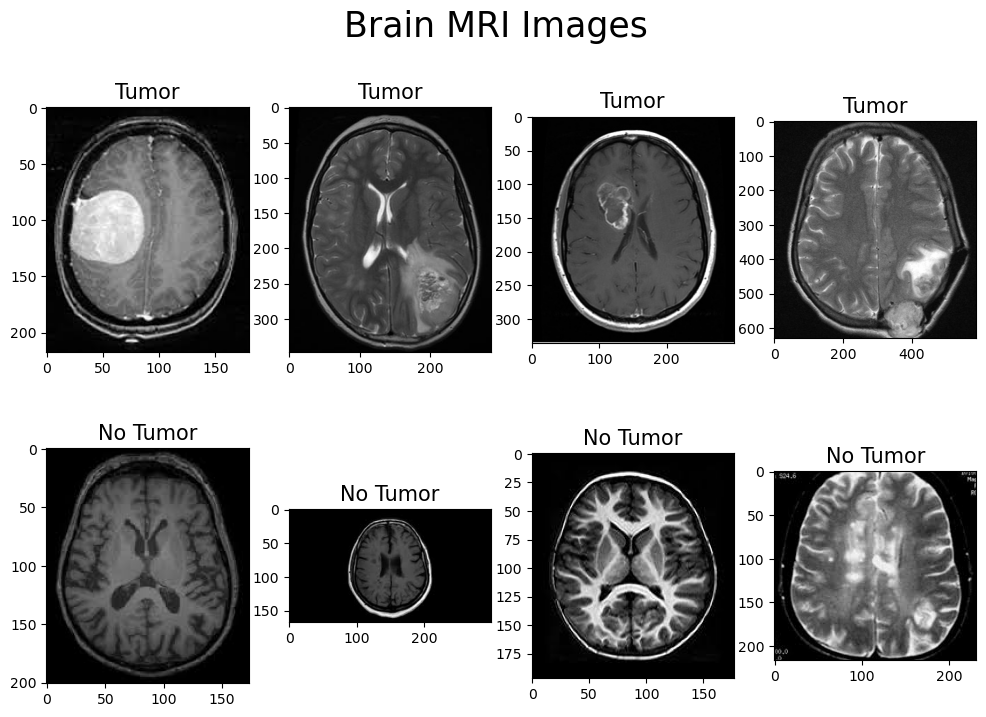

In [6]:
n_images = 4
fig, ax = plt.subplots(2, n_images, figsize=(12, 8))
fig.suptitle('Brain MRI Images', fontsize=25)
for i, class_name in enumerate(['yes', 'no']):
    source = f'{train_path}/{class_name}/'
    names = os.listdir(source)
    for j in range(n_images):    
        image = cv2.imread(f'{source}/{names[j]}')
        ax[i, j].imshow(image, cmap='gray')
        title = 'Tumor' if class_name == 'yes' else 'No Tumor'
        ax[i, j].set_title(title, fontsize=15)


In [7]:
widths = []
heights = []
labels = []
for path in [train_path, val_path, test_path]:
    for class_name in ['yes', 'no']:
        source = f'{path}/{class_name}/'
        file_names = os.listdir(source)
        for name in file_names:
            img_src = str(source + name)       
            image = cv2.imread(img_src)
            widths.append(image.shape[0])
            heights.append(image.shape[1])
            labels.append(class_name)
            
df_dims = pd.DataFrame(
    {
        'Width': widths,
        'Height': heights,
        'Label': labels
    }
)

In [8]:
df_dims.describe()

,Width,Height
count,253.000000,253.000000
mean,386.019763,354.237154
std,213.128463,217.111684
min,168.000000,150.000000
25%,248.000000,225.000000
50%,331.000000,278.000000
75%,442.000000,400.000000
max,1427.000000,1920.000000


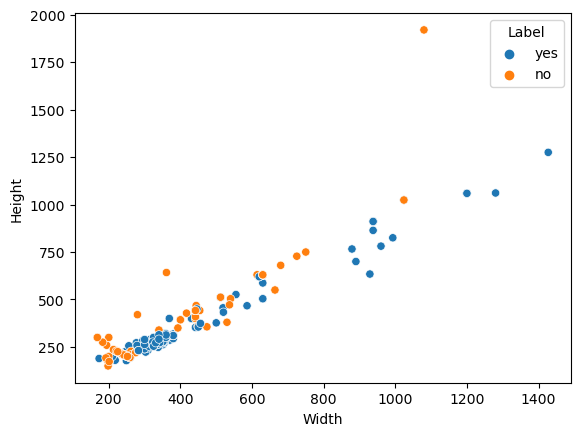

In [9]:
sns.scatterplot(df_dims, x='Width', y='Height', hue='Label');

In [14]:
def reshape(image):
    '''
    Reshape image to 2D grayscale.
    '''
    output = copy(image)
    if len(output.shape) == 3:
        # If shape is (x, y, 1), squeeze last dimension
        if output.shape[2] == 1:
            output = np.squeeze(output, axis=-1)
        # If shape is (x, y, 3), make it grayscale
        elif output.shape[2] == 3:
            output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
        # If shape is (x, y, 4), discard last dimension
        # (only populated by value 1). Other values are 
        # normalised, so convert them into [0, 255] range.
        # Then convert to grayscale.
        elif output.shape[2] == 4:
            output = output[:, :, :-1]*255
            output = output.astype(np.uint8)
            output = cv2.cvtColor(output, cv2.COLOR_RGB2GRAY)
    return output

def crop_image(image, add_pixels=0):
    """
    Finds the extreme points on the image and crops it.
    """
    output = copy(image)
    blurred = cv2.GaussianBlur(output, (5, 5), 0)
    
    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    thresh = np.array(thresh, dtype=np.uint8)
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    output = output[
        extTop[1] - add_pixels : extBot[1] + add_pixels,
        extLeft[0] - add_pixels : extRight[0] + add_pixels
    ]
    output = np.array(output)
    return output
    
            

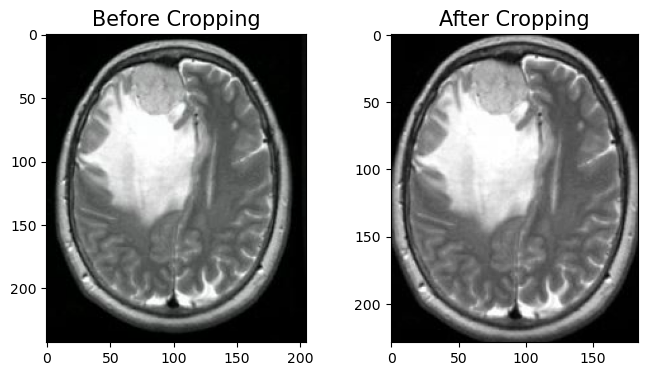

In [15]:
image_path = f'{train_path}/yes/Y65.JPG'
image_before = cv2.imread(image_path)
image_after = reshape(image_before)
image_after = crop_image(image_after)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(image_before, cmap='gray')
ax[0].set_title('Before Cropping', fontsize=15)
ax[1].imshow(image_after, cmap='gray')
ax[1].set_title('After Cropping', fontsize=15);

In [16]:
for path in [train_path, val_path, test_path]:
    for class_name in ['yes', 'no']:
        source = f'{path}/{class_name}'
        names = os.listdir(source)
        for name in names:
            img_path = f'{source}/{name}'
            image = cv2.imread(img_path)
            image = reshape(image)
            image = crop_image(image)
            cv2.imwrite(img_path, image)

In [17]:
def plot_history(history, ax=None):
    df = pd.DataFrame(history.history)
    df = df.rename(
        columns={
            'loss': 'Training Loss',
            'accuracy': 'Training Accuracy',
            'val_loss': 'Validation Loss',
            'val_accuracy': 'Validation Accuracy'
        }
    )
    if ax is None:
        fig, ax = plt.subplots()
    df.plot(ax=ax)
    ax.set_xlabel('Epoch')
    return ax

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm , index=['0', '1'] , columns=['0', '1'])

    plt.figure(figsize = (6,5))
    sns.heatmap(
        cm, cmap='Blues', linecolor='black',
        linewidth=1 , annot=True, fmt='',
        xticklabels = ['Predicted Normal', 'Predicted Tumor'],
        yticklabels = ['Actual Normal', 'Actual Tumor']
    )
    plt.yticks(rotation=0)
    plt.show()

In [20]:
train_gen = ImageDataGenerator(rescale=1./255)

# ImageDataGenerator for validation and testing images
test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)
val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)


Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [19]:
y_train_labels = train_set.classes
class_weight_list = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
CLASS_WEIGHT = dict(zip(np.unique(y_train_labels), class_weight_list))
print(CLASS_WEIGHT)

{0: 1.2941176470588236, 1: 0.8148148148148148}


In [21]:
model1 = Sequential(
    [
        Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=TARGET_SIZE + (1,)),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=8, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=4, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 4)           292       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 4)           0

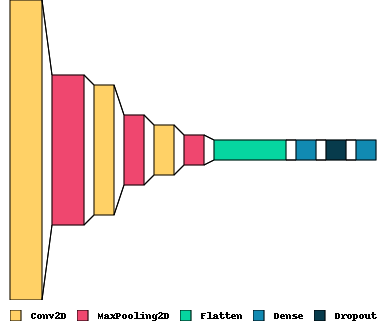

In [22]:
visualkeras.layered_view(model1, legend=True, draw_volume=False, scale_xy=10, scale_z=2)


In [23]:
model1.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-5),
    metrics=['accuracy']
)

In [24]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=30
)

In [25]:
history1 = model1.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)

Epoch 1/100
6/6 [==============================] - 6s 916ms/step - loss: 0.6977 - accuracy: 0.3864 - val_loss: 0.6982 - val_accuracy: 0.4200
Epoch 2/100
6/6 [==============================] - 1s 87ms/step - loss: 0.6932 - accuracy: 0.4545 - val_loss: 0.6921 - val_accuracy: 0.5800
Epoch 3/100
6/6 [==============================] - 1s 99ms/step - loss: 0.6941 - accuracy: 0.5398 - val_loss: 0.6914 - val_accuracy: 0.6000
Epoch 4/100
6/6 [==============================] - 1s 132ms/step - loss: 0.6927 - accuracy: 0.5795 - val_loss: 0.6913 - val_accuracy: 0.6400
Epoch 5/100
6/6 [==============================] - 1s 137ms/step - loss: 0.6917 - accuracy: 0.6193 - val_loss: 0.6952 - val_accuracy: 0.4600
Epoch 6/100
6/6 [==============================] - 1s 130ms/step - loss: 0.6920 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.5200
Epoch 7/100
6/6 [==============================] - 1s 102ms/step - loss: 0.6901 - accuracy: 0.5114 - val_loss: 0.6957 - val_accuracy: 0.3000
Epoch 8/100
6/6

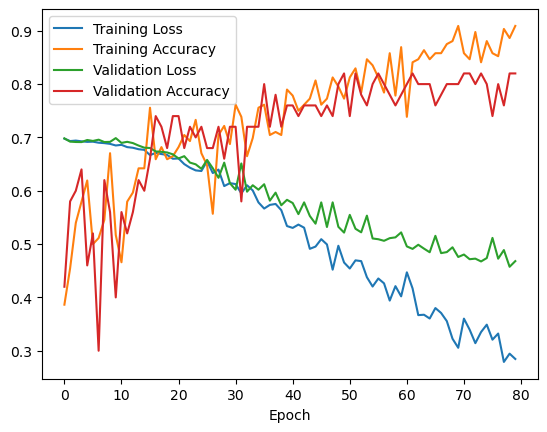

In [27]:
plot_history(history1);

In [28]:
y_true = test_set.classes
y_prob = model1.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 0s 309ms/step


In [29]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61        11
           1       0.73      0.69      0.71        16

    accuracy                           0.67        27
   macro avg       0.66      0.66      0.66        27
weighted avg       0.67      0.67      0.67        27



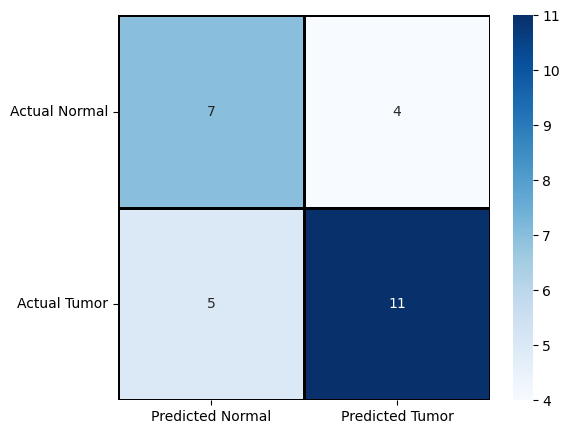

In [30]:
plot_confusion_matrix(y_true, y_pred)

In [31]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=SEED
)


Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [32]:
model2 = Sequential(
    [
        Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=TARGET_SIZE + (1,)),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=16, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Conv2D(filters=8, kernel_size=3, activation='relu'),
        MaxPooling2D(pool_size=2, padding='same'),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 8)           1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 8)          

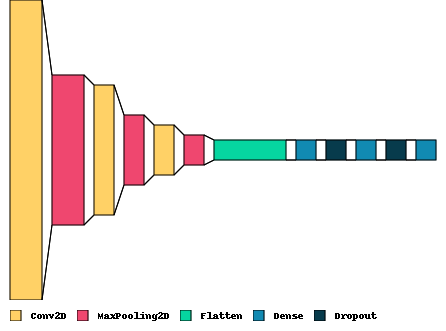

In [33]:
visualkeras.layered_view(model2, legend=True, draw_volume=False, scale_xy=10, scale_z=1)


In [34]:
model2.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-6),
    metrics=['accuracy']
)

In [35]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=40
)

In [36]:
history2 = model2.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)


Epoch 1/100
6/6 [==============================] - 3s 158ms/step - loss: 0.6929 - accuracy: 0.4432 - val_loss: 0.6925 - val_accuracy: 0.5400
Epoch 2/100
6/6 [==============================] - 1s 112ms/step - loss: 0.6934 - accuracy: 0.4773 - val_loss: 0.6927 - val_accuracy: 0.6200
Epoch 3/100
6/6 [==============================] - 1s 103ms/step - loss: 0.6930 - accuracy: 0.6023 - val_loss: 0.6924 - val_accuracy: 0.6400
Epoch 4/100
6/6 [==============================] - 1s 112ms/step - loss: 0.6926 - accuracy: 0.6193 - val_loss: 0.6924 - val_accuracy: 0.6400
Epoch 5/100
6/6 [==============================] - 1s 136ms/step - loss: 0.6931 - accuracy: 0.4148 - val_loss: 0.6921 - val_accuracy: 0.6000
Epoch 6/100
6/6 [==============================] - 1s 87ms/step - loss: 0.6921 - accuracy: 0.6023 - val_loss: 0.6915 - val_accuracy: 0.7000
Epoch 7/100
6/6 [==============================] - 1s 92ms/step - loss: 0.6922 - accuracy: 0.4886 - val_loss: 0.6907 - val_accuracy: 0.7600
Epoch 8/100
6/6

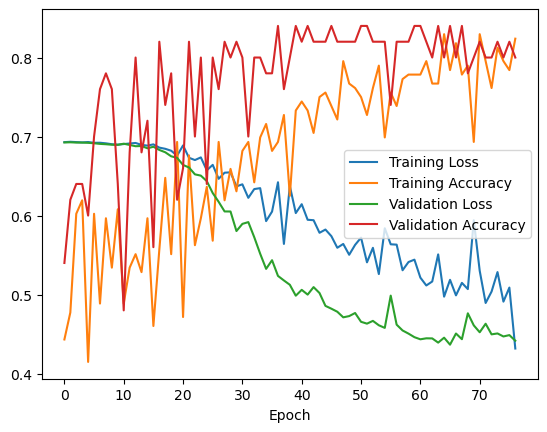

In [38]:
plot_history(history2);

In [39]:
y_true = test_set.classes
y_prob = model2.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 0s 248ms/step


In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        11
           1       0.87      0.81      0.84        16

    accuracy                           0.81        27
   macro avg       0.81      0.82      0.81        27
weighted avg       0.82      0.81      0.82        27



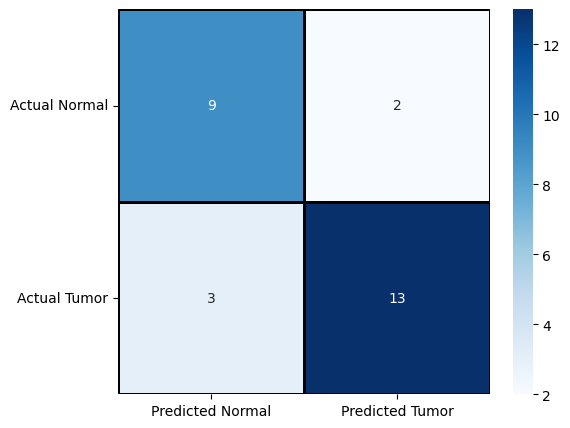

In [41]:
plot_confusion_matrix(y_true, y_pred)

In [42]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

train_set = train_gen.flow_from_directory(
    train_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=SEED
)
val_set = test_gen.flow_from_directory(
    val_path,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=SEED
)

test_set = test_gen.flow_from_directory(
    test_path,
    target_size=TARGET_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    seed=SEED
)

Found 176 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [43]:
base_model = ResNet50V2(input_shape=TARGET_SIZE + (3,), include_top=False)
base_model.trainable = False

# Define third model
model3 = Sequential(
    [
        base_model, 
        GAP(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ]
)
model3.summary()

94668760/94668760 [==============================] - 18s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1, 1, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 32)                65568     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [45]:
model3.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-5),
    metrics=['accuracy']
)

In [46]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=30
)

In [47]:
history3 = model3.fit(
    train_set,
    validation_data=val_set,
    epochs=100,
    callbacks=[es],
    class_weight=CLASS_WEIGHT
)

Epoch 1/100
6/6 [==============================] - 8s 459ms/step - loss: 0.6936 - accuracy: 0.6250 - val_loss: 0.5968 - val_accuracy: 0.6600
Epoch 2/100
6/6 [==============================] - 1s 169ms/step - loss: 0.6338 - accuracy: 0.6477 - val_loss: 0.5976 - val_accuracy: 0.6800
Epoch 3/100
6/6 [==============================] - 1s 179ms/step - loss: 0.6208 - accuracy: 0.7443 - val_loss: 0.5991 - val_accuracy: 0.7000
Epoch 4/100
6/6 [==============================] - 1s 190ms/step - loss: 0.6013 - accuracy: 0.6705 - val_loss: 0.5782 - val_accuracy: 0.7200
Epoch 5/100
6/6 [==============================] - 1s 169ms/step - loss: 0.5873 - accuracy: 0.6989 - val_loss: 0.5596 - val_accuracy: 0.7600
Epoch 6/100
6/6 [==============================] - 1s 213ms/step - loss: 0.5711 - accuracy: 0.7159 - val_loss: 0.5448 - val_accuracy: 0.7600
Epoch 7/100
6/6 [==============================] - 1s 200ms/step - loss: 0.5300 - accuracy: 0.7159 - val_loss: 0.5195 - val_accuracy: 0.7800
Epoch 8/100
6

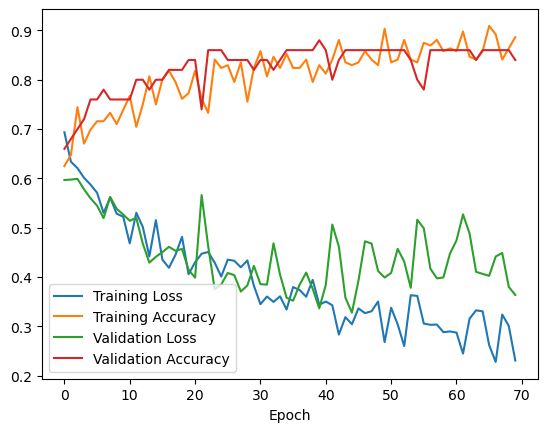

In [49]:
plot_history(history3);

In [50]:
y_true = test_set.classes
y_prob = model3.predict(test_set)
y_pred = np.where(y_prob > 0.5, 1, 0)

1/1 [==============================] - 1s 1s/step


In [51]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.81      0.81      0.81        16

    accuracy                           0.78        27
   macro avg       0.77      0.77      0.77        27
weighted avg       0.78      0.78      0.78        27



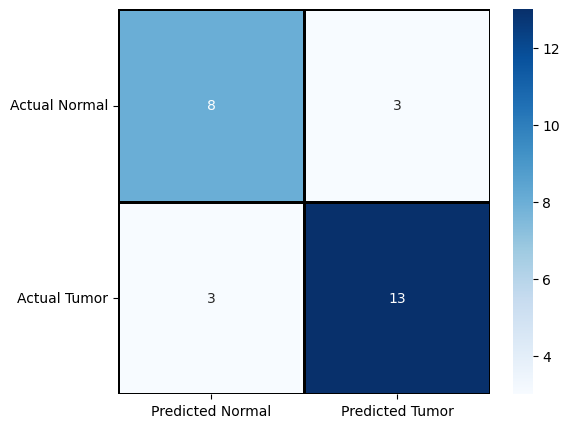

In [52]:
plot_confusion_matrix(y_true, y_pred)